In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
os.system('tar -xzf time_evo_csv.tar.gz')

0

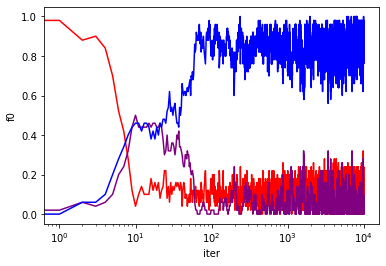

In [3]:
# A single trajectory:
df = pd.read_csv('time_evo_csv/time_evo_rea_001.csv')
sns.lineplot(data=df,x='iter',y='f0',color='red')
sns.lineplot(data=df,x='iter',y='f1',color='purple')
sns.lineplot(data=df,x='iter',y='f2',color='blue')
plt.xscale('log')

In [4]:
# Read all the output trajectories and put them in df_list
def file_id(i):
    if 1 <= i <= 9:
        file_id = '00'+str(i)
    elif 10 <= i <= 99:
        file_id = '0'+str(i)
    else:
        file_id = str(i)
    return file_id

num_files = len(os.listdir('time_evo_csv/'))
df_list = []
for i in range(1,num_files+1):
    df = pd.read_csv(f'time_evo_csv/time_evo_rea_{file_id(i)}.csv')
    df_list.append(df)

In [5]:
for df in df_list:
    df['Q'] = df['f2']-2*df['f1']

In [6]:
df_list[0].head()

,iter,f0,f1,f2,Q
0,0,1.00,0.00,0.00,0.00
1,1,0.98,0.02,0.00,-0.04
2,2,0.88,0.06,0.06,-0.06
3,3,0.90,0.04,0.06,-0.02
4,4,0.84,0.06,0.10,-0.02


In [7]:
# AVERAGED TRAJECTORIES:
from functools import reduce
df_avg = reduce(lambda a, b: a.add(b, fill_value=0), [df.drop(['iter'], axis=1) for df in df_list])
df_avg = df_avg/num_files
df_sd = reduce(lambda a, b: a.add(b, fill_value=0), [(df.drop(['iter'], axis=1)-df_avg)**2 for df in df_list])
df_sd = np.sqrt(df_sd/(num_files-1))

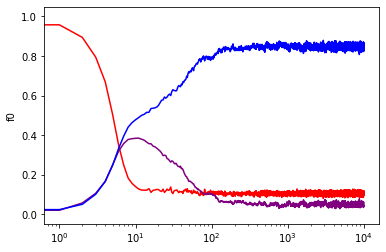

In [8]:
# Plot averaged trajectories:
sns.lineplot(data=df_avg,x=df_avg.index,y='f0',color='red')
sns.lineplot(data=df_avg,x=df_avg.index,y='f1',color='purple')
sns.lineplot(data=df_avg,x=df_avg.index,y='f2',color='blue')
plt.xscale('log')

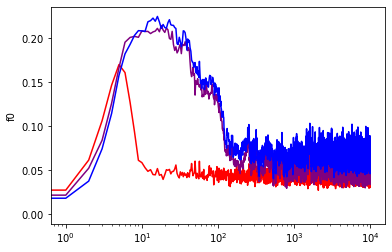

In [9]:
# Plot standard deviation of averaged trajectories:
sns.lineplot(data=df_sd,x=df_sd.index,y='f0',color='red')
sns.lineplot(data=df_sd,x=df_sd.index,y='f1',color='purple')
sns.lineplot(data=df_sd,x=df_sd.index,y='f2',color='blue')
plt.xscale('log')

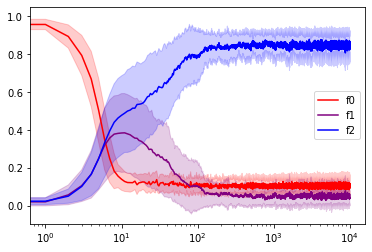

In [11]:
# AVERAGED TRAJECTORY:
# Combine standard deviation and mean in a single plot:
plt.plot(df_avg.index, df_avg['f0'], label='f0', color='red')
plt.fill_between(df_avg.index, df_avg['f0']-df_sd['f0'], df_avg['f0']+df_sd['f0'], color='red', alpha=0.2)
plt.plot(df_avg.index, df_avg['f1'], label='f1', color='purple')
plt.fill_between(df_avg.index, df_avg['f1']-df_sd['f1'], df_avg['f1']+df_sd['f1'], color='purple', alpha=0.2)
plt.plot(df_avg.index, df_avg['f2'], label='f2', color='blue')
plt.fill_between(df_avg.index, df_avg['f2']-df_sd['f2'], df_avg['f2']+df_sd['f2'], color='blue', alpha=0.2)
plt.legend()
plt.xscale('log')

In [7]:
# Average values:
print(f"Average f0: {round(df_avg['f0'][1000:].mean(),4)} +- {round(df_avg['f0'][1000:].std(),4)}")
print(f"Average f1: {round(df_avg['f1'][1000:].mean(),4)} +- {round(df_avg['f1'][1000:].std(),4)}")
print(f"Average f2: {round(df_avg['f2'][1000:].mean(),4)} +- {round(df_avg['f2'][1000:].std(),4)}")
Q = df_avg['f2'][1000:].mean() - 2*df_avg['f1'][1000:].mean()
sdQ = 2*df_avg['f1'][1000:].std()+df_avg['f2'][1000:].std()
print(f"Average Q: {round(Q,4)} +- {round(sdQ,4)}")
print(f"Average Q: {df_avg['Q'][1000:].mean()} +- {df_avg['Q'][1000:].std()}")

Average f0: 0.1037 +- 0.0062
Average f1: 0.0488 +- 0.007
Average f2: 0.8475 +- 0.0093
Average Q: 0.75 +- 0.0232
Average Q: 0.7499550272191995 +- 0.021752508603781563


In [43]:
# Block average to search for the stationary state:
# Divide trajectory in blocks of 50(?) iterations, check that some f keeps being the max during all the block
# if so, compute avg and sd

block_len = 1

#df = df_list[1]
df = df_avg
while (len(df)%block_len != 0):
    df.drop(df.tail(1).index, inplace=True)
#print(len(df))

if('iter' in df.keys()):
    max_each_row = df.drop('iter', axis=1).idxmax(axis=1)
else:
    max_each_row = df.idxmax(axis=1)

#df_block = pd.DataFrame({'iter':[], 'fmax':[]})
block_list = []
avg_list = []
std_list = []
for i in range(int(len(df)/block_len)):
    start_at = i*block_len
    fmax_start = max_each_row[start_at]
    if((max_each_row[start_at:start_at+block_len]==fmax_start).sum() == block_len):
        #print(start_at, df[fmax_start][start_at:start_at+50].mean(), df[fmax_start][start_at:start_at+50].std())
        block_list.append(start_at)
        avg_list.append(df[fmax_start][start_at:start_at+block_len].mean())
        std_list.append(df[fmax_start][start_at:start_at+block_len].std())
    else:
        if len(block_list) != 0:
            block_list.clear()
            avg_list.clear()
            std_list.clear()
            
# once terminated, put it all in a Dataframe. Necessari???
df_block = pd.DataFrame({'block':block_list, 'fmax_avg':avg_list, 'fmax_std':std_list}) # block indicates where the block has been started

# compute the relative difference between consecutive blocks, in their avg and std
avg_rel_dif_list = []
std_rel_dif_list = []
for i in range(len(block_list)-1):
    avg_rel_dif_list.append(abs(avg_list[i]-avg_list[i+1])/avg_list[i])
    std_rel_dif_list.append(abs(std_list[i]-std_list[i+1])/std_list[i])
df_block_rd = pd.DataFrame({'iter':block_list[1:], 'fmax_avg':avg_rel_dif_list, 'fmax_std':std_rel_dif_list}) # block indicates where the intermediate value bt the two blocks whose rd is computed
#df_block_rd

# compute the absolute difference
avg_abs_dif_list = []
std_abs_dif_list = []
for i in range(len(block_list)-1):
    avg_abs_dif_list.append(abs(avg_list[i]-avg_list[i+1]))
    std_abs_dif_list.append(abs(std_list[i]-std_list[i+1]))
df_block_abs = pd.DataFrame({'iter':block_list[1:], 'fmax_avg':avg_abs_dif_list, 'fmax_std':std_abs_dif_list}) # block indicates where the intermediate value bt the two blocks whose rd is computed

<AxesSubplot:xlabel='iter', ylabel='fmax_avg'>

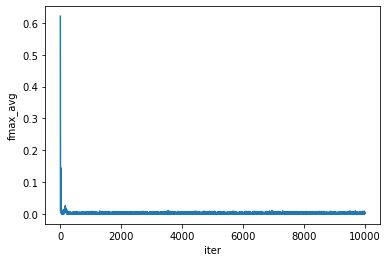

In [47]:
sns.lineplot(data=df_block_rd, x='iter', y='fmax_avg')

<AxesSubplot:xlabel='iter'>

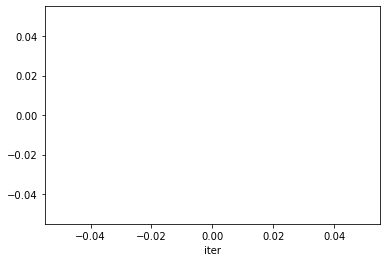

In [46]:
sns.lineplot(data=df_block_rd, x='iter', y='fmax_std')

In [11]:
# Script would end deleting the folder, just to keep the tar.gz. file
os.system('rm -r time_evo_csv')

0

In [89]:
# Trialing for avg trajectory:
df_trial_1 = pd.DataFrame({'f0':[1.0, 0.5, 0.0], 'f1':[0.0, 0.0, 0.0], 'f2':[0.0, 0.5, 1.0]})
df_trial_2 = pd.DataFrame({'f0':[1.0, 0.25, 0.0], 'f1':[0.0, 0.25, 0.0], 'f2':[0.0, 0.5, 1.0]})
df_trial_3 = pd.DataFrame({'f0':[0.0, 0.0, 0.0], 'f1':[0.5, 0.25, 0.0], 'f2':[0.5, 0.75, 1.0]})

df_avg_trial = reduce(lambda a, b: a.add(b, fill_value=0), [df_trial_1, df_trial_2, df_trial_3])
df_avg_trial = df_avg_trial/3

#df_sd_trial = (df_trial_1 - df_avg_trial)**2 + (df_trial_2 - df_avg_trial)**2
#df_sd_trial = np.sqrt(df_sd_trial/(2-1))
# to comprehension:
sd_func = lambda df: (df-df_avg_trial)**2
df_sd_trial = pd.DataFrame({'f0':np.zeros(3), 'f1':np.zeros(3), 'f2':np.zeros(3)})
for df in [df_trial_1, df_trial_2, df_trial_3]:
    df_sd_trial = df_sd_trial + sd_func(df)
df_sd_trial = np.sqrt(df_sd_trial/(3-1))

all_dfs = [df_trial_1, df_trial_2, df_trial_3]
df_sd_trial_2 = reduce(lambda a,b: a+b, [(df-df_avg_trial)**2 for df in all_dfs])
df_sd_trial_2 = np.sqrt(df_sd_trial_2/(3-1))
df_sd_trial_2